<a href="https://colab.research.google.com/github/codyshen0000/My_Test_Code/blob/main/Normalizing%20flows%20in%20PyTorch%20(part%201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch distributions
利用pytorch的distributions 工具箱




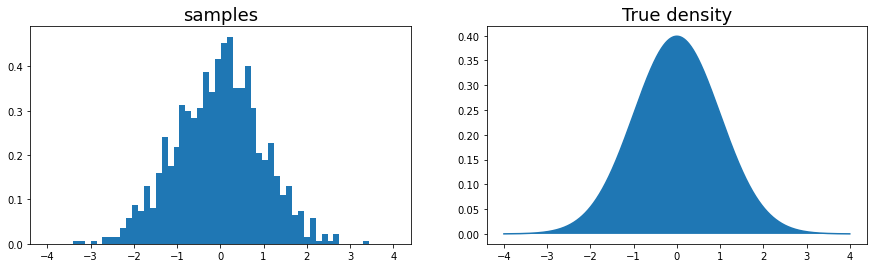

In [5]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import matplotlib.pyplot as plt
import torch.distributions.transforms as transform
import torch.nn.functional as F
import numpy as np
%matplotlib inline
import pdb
x = np.linspace(-4, 4, num=1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
# pdb.set_trace()
disr = distrib.Normal(loc=0, scale=1)
samples = disr.sample([1000,])
# pdb.set_trace()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
density = torch.exp(disr.log_prob(torch.Tensor(x))).numpy()
ax1.hist(samples, 50, density=True);
ax1.set_title('samples',fontsize=18)
ax2.plot(x,density)
# alpha means color depth
ax2.fill_between(x, density, 0, alpha=1)
ax2.set_title('True density', fontsize=18);


# Transforming distributions
所谓分布变换，即是求关于随机变量的函数的分布比如。$x\sim N(0,1)$，$y=f(x)$在定义域内一一对应，则$y$的概率分布是多少？
假设$x\in{\mathcal{R}^d}$, $f:\mathcal{R}^d \rightarrow \mathcal{R}^d$,则概率分布$q(y)=p(x)\left|\text{det}{\frac{\partial f^{-1}}{\partial x}}\right|=p(x)|det{\frac{\partial f}{\partial x}}|^{-1}$

利用 pytorch 的transform 类，我们可以实现较为简单的逆变换。例如：$\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$,  $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$



Text(0.5, 1.0, '$q_1 = exp(q_0)$')

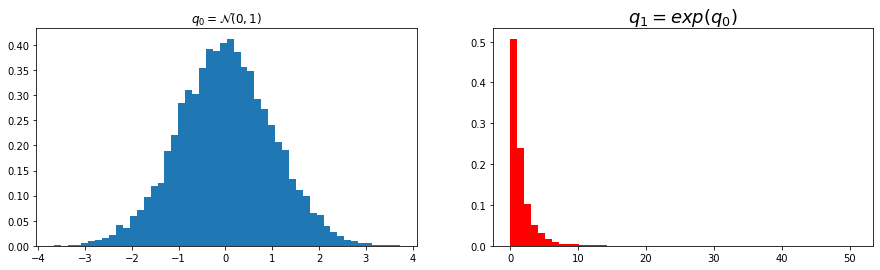

In [6]:

q0 = distrib.Normal(0,1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, exp_t)
q2 = distrib.LogNormal(0,1)
samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))
fig, (axis1, axis2) = plt.subplots(1,2,sharex=False, figsize=(15, 4))
axis1.hist(samples_q0, 50, density=True,)
axis1.set_title('$q_0 = \mathcal{N}(0,1)$')
axis2.hist(samples_q1, 50, density=True, color='red',)
axis2.set_title('$q_1 = exp(q_0)$', fontsize=18)


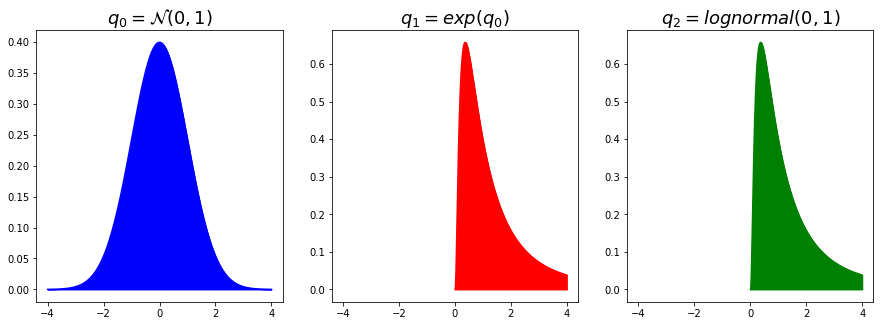

In [7]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x))).numpy()
q2_density = torch.exp(q2.log_prob(torch.Tensor(x))).numpy()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, figsize=(15,5))
ax1.plot(x, q0_density,color='b')
ax1.fill_between(x, q0_density, 0, alpha=1, color='b')
ax1.set_title('$q_0 = \mathcal{N}(0,1)$', fontsize=18);
ax2.plot(x, q1_density, color='r')
ax2.set_title('$q_1 = exp(q_0)$', fontsize=18,);
ax2.fill_between(x, q1_density, 0, alpha=1, color='r')
ax3.plot(x, q2_density, color='g')
ax3.set_title('$q_2 = lognormal(0,1)$', fontsize=18,);
ax3.fill_between(x, q2_density, 0, alpha=1, color='g')

# Chaining transforms (normalizing flows)
现实中的概率往往十分复杂，因此数据流需要经过一系列双射（可逆映射）最终才能映射到合适的表征空间，并且这些一系列映射的积分为1，因此称之为normaliziing

$y=f_k \circ f_{k-1}\circ\cdots\circ f_1(x)$
因此，可得$y\sim q(y)$的值为：
\begin{equation}
  q(y)=p_0(x)\prod_{i=1}^k|\text{det}\frac 
  {\partial f_{i}}{\partial x_{i-1}}|^{-1}
  \tag{1}
\end{equation}
利用对数似然简化计算
\begin{equation}
  log(q(y))=log(p_0(x))-\sum_{i=1}^k log|\text{det}\frac {\partial f_{i}}{\partial x_{i-1}}|
  \tag{2}
\end{equation}
实践中如何使用呢？

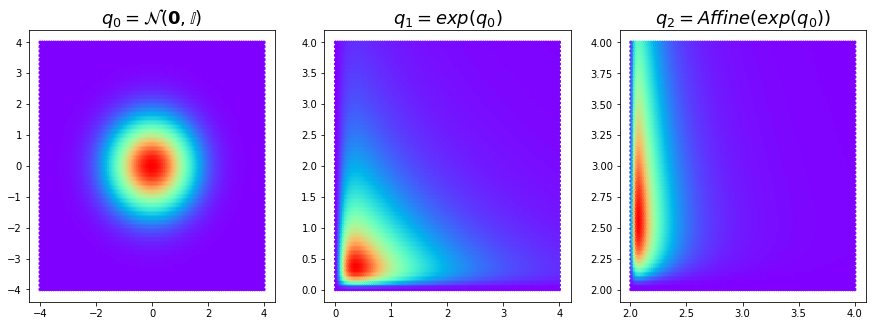

In [8]:
# X ~ Uniform(0, 1)
# f = a + b * logit(X)
# Y ~ f(X) ~ Logistic(a, b)
# base_distribution = Uniform(0, 1)
# transforms = [SigmoidTransform().inv, AffineTransform(loc=a, scale=b)]
# logistic = TransformedDistribution(base_distribution, transforms)

q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18);
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18);

# Normalizing flows
[planar](http://arxiv.org/pdf/1505.05770)
flow proposed in the original paper by Rezende 
## Planar flow
\begin{equation}
  f(z)=z+u\cdot h(w^Tz+b)
  \tag{3}
\end{equation}
$u\in \mathbb{R}^d,w\in \mathbb{R}^d$.$u$是scale，$w$是权重。$b\in \mathbb R$是标量，$h$是激活函数。这些 transform functions 的选择基于以下两点：


1.   the determinant of their Jacobian can be computed in linear time
2.   the transformation is invertible (under usually mild conditions only)

对于planar flow，由matrix determinant lemma(矩阵行列式引理)可得该雅克比行列式计算复杂度为 $O(D)$
$$
\psi(\mathbf{z})=h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}
\tag{4}
$$
$$
\left|\text{det}\frac{\partial f}{\partial\mathbf{z}}\right| = \left|\text{det}\left(\mathbf{I}+\mathbf{u}\psi(\mathbf{z})^{T}\right)\right|=\left|1+\mathbf{u}^T\psi(\mathbf{z})\right|
\tag{5}
$$
这里$h$是个$tanh$,其导数为$1-tanh(x)^2$


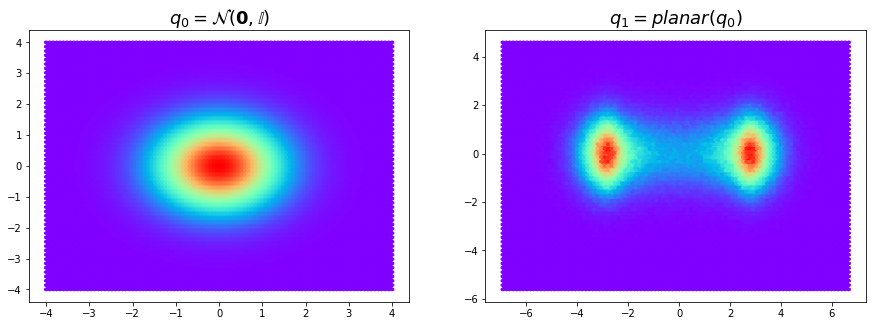

In [9]:
class PlanarFlow(transform.Transform):

  def __init__(self, weight,scale,bias):
    super(PlanarFlow, self).__init__()
    self.bijective = False
    self.weight = weight
    self.scale = scale
    self.bias = bias
  
  def _call(self, z):
      f_z = F.linear(z, self.weight, self.bias)
      return z + self.scale * torch.tanh(f_z)

  def log_abs_det_jacobian(self, z):
    f_z = F.linear(z, self.weight, self.bias)
    psi = (1 - torch.tanh(f_z) ** 2) * self.weight
    det_grad = 1 + torch.mm(psi, self.scale.t())
    return torch.log(det_grad.abs() + 1e-7)


w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)
q1 = distrib.TransformedDistribution(q0, flow_0)
q1_samples = q1.sample((int(1e6), ))
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

上面是用 PlanarFlow 去tranform 高斯分布，$q_0$是高斯分布的概率分布，右图则是样本分布，也就是通过样本采样后得到的分布，实际分布可由前面的公式推导得到，如下图所示

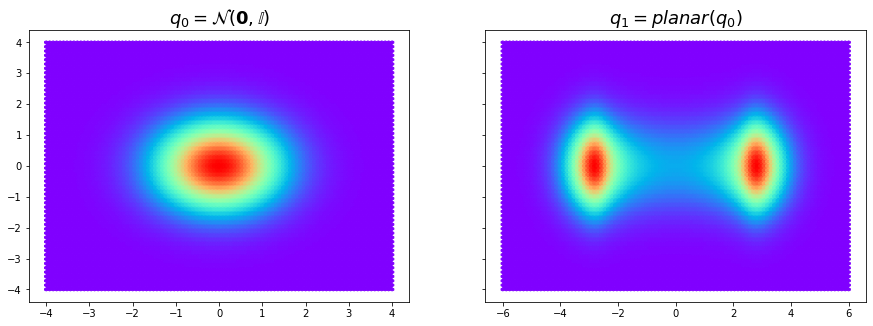

In [10]:

q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# Apply our transform on coordinates
f_z = flow_0(torch.Tensor(z))
# Obtain our density
q1_density = q0_density.squeeze() / np.exp(flow_0.log_abs_det_jacobian(torch.Tensor(z)).squeeze())
# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18);

# Visualizing parameters effects
上面的$w,h,b$都是固定参数，因此我们可以设置超参数，来可视化参数的影响。

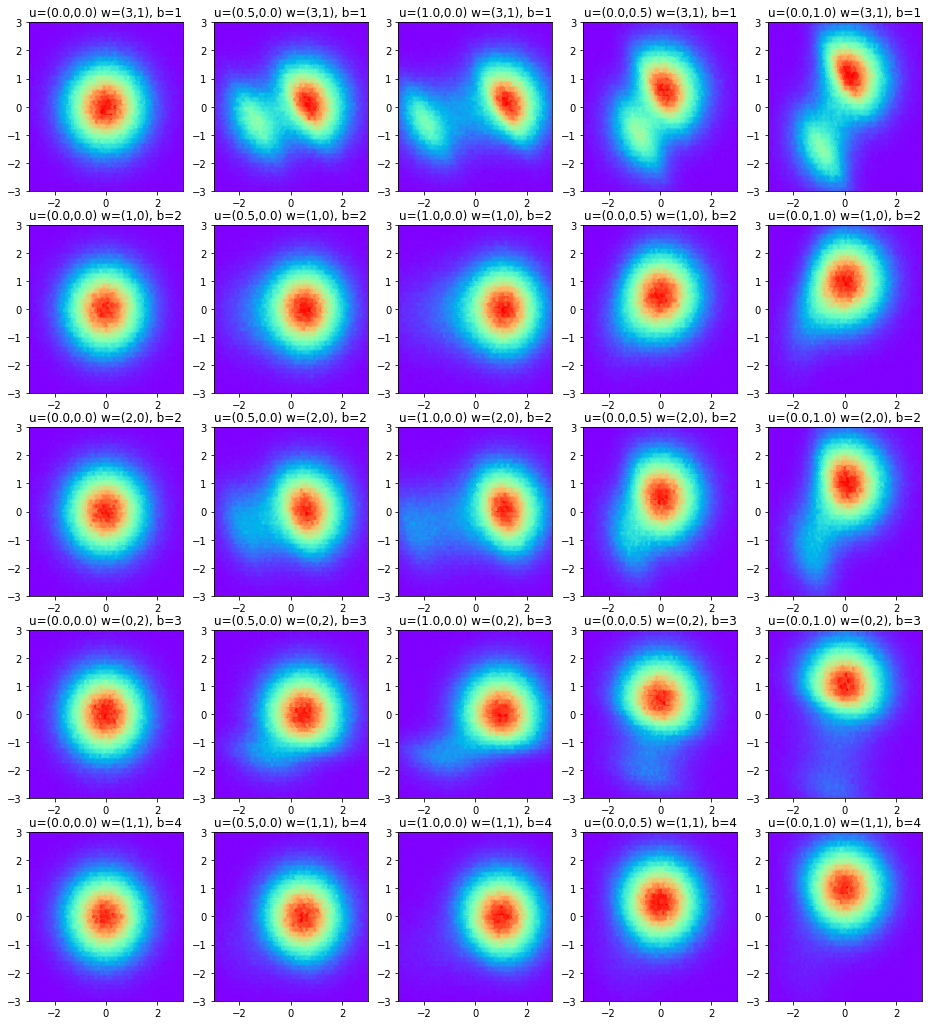

In [11]:

id_figure=1
plt.figure(figsize=(16, 18))
for i in np.arange(5):
  #Draw a random hyperplane
  w = torch.rand(1, 2) * 5
  b = torch.rand(1) * 5
  for j in np.arange(5):
  # Different effects of scaling factor u on the same hyperplane (row)
    u = torch.Tensor([[((j < 3) and (j / 2.0) or 0), ((j > 2) and ((j - 2) / 2.0) or 0)]])

    flow_0 = PlanarFlow(w, u, b)
    q1 =  distrib.TransformedDistribution(q0, flow_0)
    q1_samples=q1.sample((int(1e6), ))
    plt.subplot(5,5,id_figure)
    plt.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
    plt.title("u=(%.1f,%.1f)"%(u[0,0],u[0,1]) + " w=(%d,%d)"%(w[0,0],w[0,1]) + ", " + "b=%d"%b)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    id_figure += 1
  

# Optimizing normalizing flows
有了前面的基础，我们可以做一些更复杂的推理

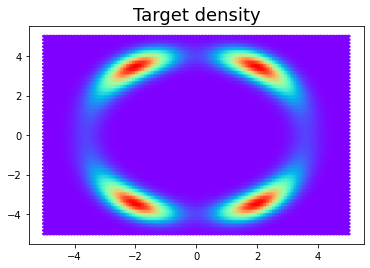

In [12]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)


class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18);

Loss (it. 0) : 18.422157
Loss (it. 1000) : 7.631508
Loss (it. 2000) : 5.872628
Loss (it. 3000) : 4.553718
Loss (it. 4000) : 4.815353
Loss (it. 5000) : 3.720608
Loss (it. 6000) : 3.612331
Loss (it. 7000) : 3.072063
Loss (it. 8000) : 2.766364
Loss (it. 9000) : 2.659488
Loss (it. 10000) : 2.504407
Loss (it. 11000) : 2.123270
Loss (it. 12000) : 2.488709
Loss (it. 13000) : 1.985352


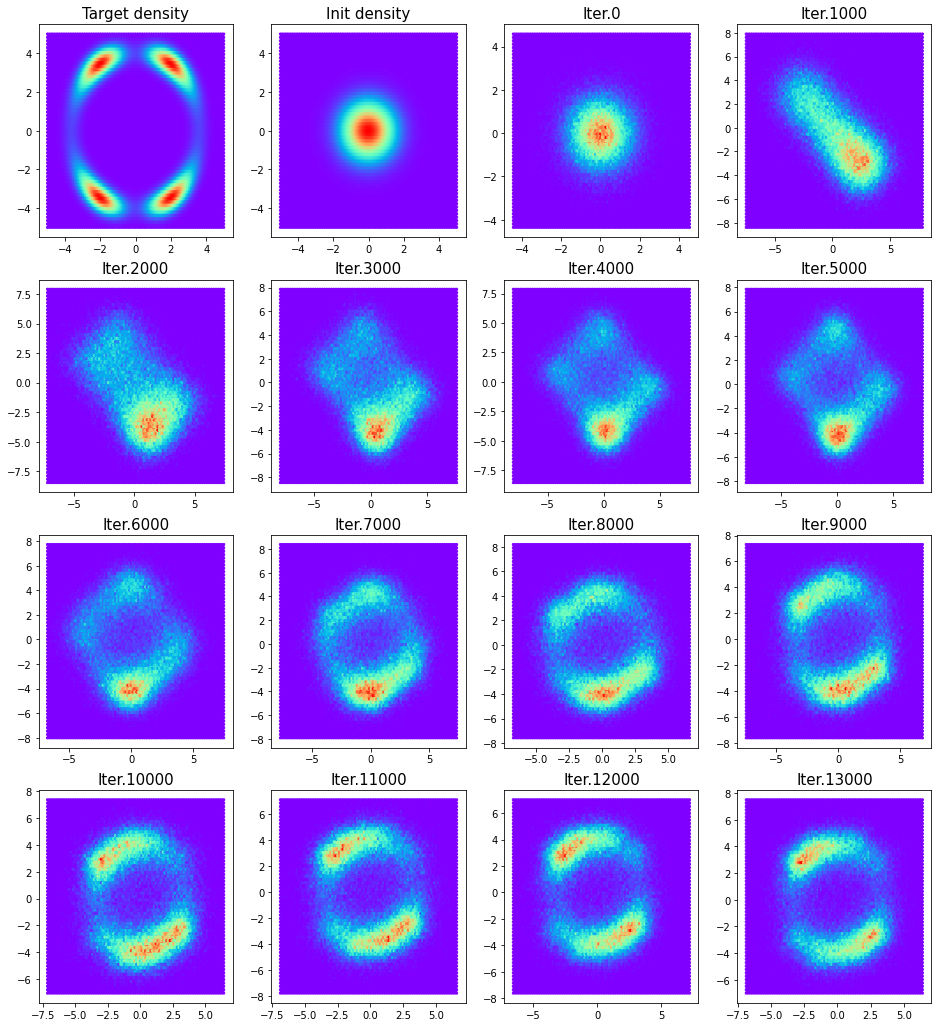

In [29]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
          biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))
# flow = flow.cuda()

#def loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk)+1e-9)).mean()
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=2e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=3
plt.figure(figsize=(16, 18))
plt.subplot(4,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
plt.subplot(4,4,2)
plt.hexbin(z[:,0], z[:,1], C=torch.exp(ref_distrib.log_prob(torch.Tensor(z))), cmap='rainbow')
plt.title('Init density', fontsize=15);
# Main optimization loop
for it in range(13001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        
        with torch.no_grad():
          # Draw random samples
          samples = ref_distrib.sample((int(1e5), ))
          # Evaluate flow and plot
          zk, _ = flow(samples)
          zk = zk.cpu().detach().numpy()
          plt.subplot(4,4,id_figure)
          plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
          plt.title('Iter.%i'%(it), fontsize=15);
          id_figure += 1

# Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html

https://github.com/ex4sperans/variational-inference-with-normalizing-flows

https://akosiorek.github.io/ml/2018/04/03/norm_flows.html

https://github.com/abdulfatir/normalizing-flows

https://github.com/acids-ircam/pytorch_flows/blob/master/flows_01.ipynb



